<img src="../../Img/img.webp" alt="Predicción del Éxito de Videojuegos" width="100%" height="300px">

<h1 style="text-align: center; font-size: 2.5em; text-decoration: underline;">MACHINE LEARNING: VALORADOR DE OPINIONES</h1>

In [1]:
# ==============================================================================
# # Manipulación de datos
# ==============================================================================

import pandas as pd
import numpy as np

# ==============================================================================
# Preprocesamiento de texto
# ==============================================================================

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==============================================================================
# Detección de idioma
# ==============================================================================

from langdetect import detect

# ==============================================================================
# Modelado y evaluación
# ==============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==============================================================================
# Visualización
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# Guardado de modelos
# ==============================================================================

import pickle

# ==============================================================================
# Descargar recursos necesarios para nltk
# ==============================================================================

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ==============================================================================
# Configuración warnings
# ==============================================================================

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\buque\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Cargar y Explorar el Dataset
Cargamos el dataset y exploramos su estructura inicial.

In [36]:
# ==============================================================================
# Load the dataset
# ==============================================================================
dataset = pd.read_csv('../Data/dataset_reviews_cleaned.csv')
dataset

,Unnamed: 0,Contenido,Valoración,Recomendado_binario
0,0,2 marzo so bad,No recomendado,0
1,1,10 febrero actualmente recomiendo juego contab...,No recomendado,0
2,2,9 febrero increíblemente gracioso ver cómo cdp...,No recomendado,0
3,3,the world in this game is extremely static the...,No recomendado,0
4,4,zero replayability i finished this game in abo...,No recomendado,0
...,...,...,...,...
19995,19995,si,Recomendado,1
19996,19996,cojonudo,Recomendado,1
19997,19997,reostia historia guapisima graficos impresiona...,Recomendado,1
19998,19998,basicamente sublime obra maestra,Recomendado,1


# Manejo de Valores Nulos
Observamos que hay 288 valores nulos en la columna Contenido. Vamos a eliminar estos registros ya que representan una pequeña fracción del dataset total (20,000 comentarios).

# Limpieza y Preprocesamiento de Texto

In [37]:
missing_values = dataset.isnull().sum()
basic_stats = dataset.describe()

missing_values, basic_stats

(Unnamed: 0               0
 Contenido              288
 Valoración               0
 Recomendado_binario      0
 dtype: int64,
          Unnamed: 0  Recomendado_binario
 count  20000.000000         20000.000000
 mean    9999.500000             0.500000
 std     5773.647028             0.500013
 min        0.000000             0.000000
 25%     4999.750000             0.000000
 50%     9999.500000             0.500000
 75%    14999.250000             1.000000
 max    19999.000000             1.000000)

- Eliminar registros con valores nulos en Contenido.
- Convertir el texto a minúsculas.
- Eliminar caracteres especiales, puntuación y dígitos.
- Tokenizar y lematizar.

In [38]:
dataset = dataset.dropna(subset=['Contenido'])

In [39]:
dataset['Contenido'] = dataset['Contenido'].str.lower()

In [40]:
dataset['Contenido'] = dataset['Contenido'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [41]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

dataset['Contenido'] = dataset['Contenido'].apply(preprocess_text)
dataset


,Unnamed: 0,Contenido,Valoración,Recomendado_binario
0,0,marzo so bad,No recomendado,0
1,1,febrero actualmente recomiendo juego contaba r...,No recomendado,0
2,2,febrero increblemente gracioso ver cmo cdpr de...,No recomendado,0
3,3,the world in this game is extremely static the...,No recomendado,0
4,4,zero replayability i finished this game in abo...,No recomendado,0
...,...,...,...,...
19995,19995,si,Recomendado,1
19996,19996,cojonudo,Recomendado,1
19997,19997,reostia historia guapisima graficos impresiona...,Recomendado,1
19998,19998,basicamente sublime obra maestra,Recomendado,1


# EDA: Análisis Exploratorio de Datos
Voy a hacer un pequeño EDA, ya que conseguí un dataset bastante limpio y lo que estoy haciendo es procesamiento de lenguaje natural, tampoco espero ver mucha relacion entre las features.

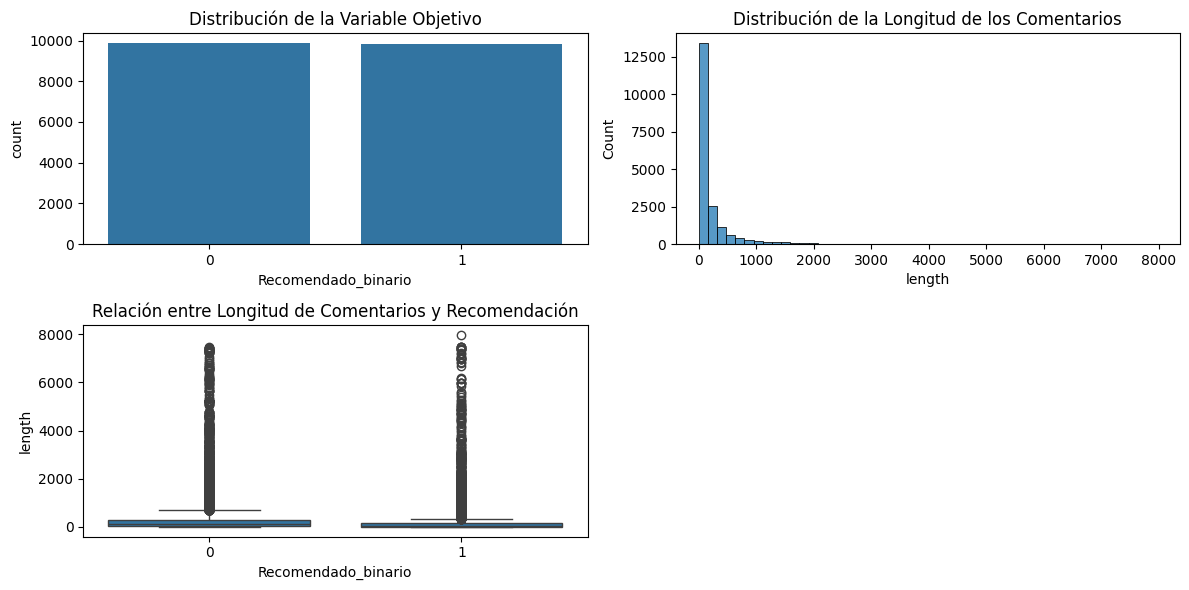

In [65]:
plt.figure(figsize=(12, 6))

# Distribución de la variable objetivo
plt.subplot(2, 2, 1)
sns.countplot(x='Recomendado_binario', data=dataset)
plt.title('Distribución de la Variable Objetivo')

# Longitud de los comentarios
dataset['length'] = dataset['Contenido'].apply(len)
plt.subplot(2, 2, 2)
sns.histplot(dataset['length'], bins=50)
plt.title('Distribución de la Longitud de los Comentarios')

# Relación entre la longitud de los comentarios y la recomendación
plt.subplot(2, 2, 3)
sns.boxplot(x='Recomendado_binario', y='length', data=dataset)
plt.title('Relación entre Longitud de Comentarios y Recomendación')

plt.tight_layout()
plt.show()

El conjunto de datos está equilibrado, con una distribución igualitaria de comentarios positivos y negativos, lo que garantiza que el modelo pueda aprender de ambos tipos de opiniones.

# Vectorización del Texto
Utilizaremos TF-IDF (Term Frequency-Inverse Document Frequency) para convertir el texto en vectores numéricos.

In [43]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset['Contenido']).toarray()
y = dataset['Recomendado_binario']

# División del Dataset
Vamos a separar el dataset en conjuntos de entrenamiento y prueba.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento y Evaluación de Modelos
Entrenaremos modelos de Regresion Logística, SVC (Support Vector Classification) y Random Forest.

In [45]:
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "SVM": SVC(),
#     "Random Forest": RandomForestClassifier()
# }

In [46]:
# for model_name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Results for {model_name}:")
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

Results for Logistic Regression

          precision    recall  f1-score   support

       0       0.87      0.86      0.86      1968
       1       0.86      0.88      0.87      1975
       accuracy                    0.87      3943

**Accuracy:** 0.8660918082678164

Results for SVM

          precision    recall  f1-score   support

       0       0.89      0.89      0.89      1968
       1       0.89      0.89      0.89      1975
       accuracy                    0.89      3943

**Accuracy:** 0.8904387522191225

Results for Random Forest

          precision    recall  f1-score   support

       0       0.85      0.90      0.87      1968
       1       0.89      0.84      0.86      1975
       accuracy                    0.87      3943

**Accuracy:** 0.8663454222673092

### Evaluación de Overfitting
Para evaluar el overfitting, vamos a comparar las métricas de los conjuntos de entrenamiento y prueba

In [47]:
# for model_name, model in models.items():
#     y_train_pred = model.predict(X_train)
#     print(f"Training Results for {model_name}:")
#     print(classification_report(y_train, y_train_pred))
#     print(confusion_matrix(y_train, y_train_pred))
#     print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}\n")

Training Results for Logistic Regression

          precision    recall  f1-score   support

        0       0.90      0.89      0.90      7917
        1       0.89      0.90      0.90      7852
        accuracy                    0.90     15769

**Training Accuracy:** 0.8975838670809817

Training Results for SVM

          precision    recall  f1-score   support

       0       0.98      0.96      0.97      7917
       1       0.96      0.98      0.97      7852
       accuracy                    0.97     15769

**Training Accuracy:** 0.9675312321643731

Training Results for Random Forest

          precision    recall  f1-score   support

       0       0.99      0.97      0.98      7917
       1       0.97      0.99      0.98      7852
       accuracy                    0.98     15769

**Training Accuracy:** 0.98

Estamos ante un caso de overfitting, claramente, dado que los resultados en el conjunto de prueba son significativamente peores que los resultados casi perfectos obtenidos durante el entrenamiento.

### Mitigación de Overfitting
Para reducir el overfitting en los modelos de SVM y Random Forest, podemos aplicar varias técnicas:

- Regularización para SVM: Ajustar el parámetro de regularización C para encontrar un equilibrio entre el ajuste del modelo y la simplicidad.
- Reducción de la Complejidad del Random Forest: Limitar la profundidad máxima de los árboles y reducir el número de estimadores.
- Cross-validation: Utilizar la validación cruzada para evaluar el rendimiento del modelo y ajustar los hiperparámetros de manera más robusta.

In [48]:
logreg_params = {'C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, scoring='accuracy')
logreg_grid.fit(X_train, y_train)
best_logreg = logreg_grid.best_estimator_

**3 min, rapidito.**

In [49]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

**70 -80 min para correr este gridsearch**

In [50]:
# svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
# svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
# svm_grid.fit(X_train, y_train)
# best_svm = svm_grid.best_estimator_

**400 min para correr este gridsearch**

In [51]:
models = {
    "Logistic Regression": best_logreg,
    # "Best SVM": best_svm,
    "Best Random Forest": best_rf
}

In [53]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

    # Evaluación en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    print(f"Training Results for {model_name}:")
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}\n")

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1968
           1       0.87      0.88      0.88      1975

    accuracy                           0.88      3943
   macro avg       0.88      0.88      0.88      3943
weighted avg       0.88      0.88      0.88      3943

[[1718  250]
 [ 234 1741]]
Accuracy: 0.8772508242454984

Training Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7917
           1       0.93      0.94      0.94      7852

    accuracy                           0.94     15769
   macro avg       0.94      0.94      0.94     15769
weighted avg       0.94      0.94      0.94     15769

[[7391  526]
 [ 439 7413]]
Training Accuracy: 0.9388039824973048

Results for Best SVM:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1968
           1     

Los resultados muestran que todavía hay una diferencia significativa entre las métricas de entrenamiento y prueba, especialmente en el modelo Random Forest, lo que indica que hay overfitting en el modelo Random Forest. El modelo de Logistic Regression parece tener un rendimiento más consistente entre los conjuntos de entrenamiento y prueba, aunque aún existe una ligera diferencia.

### Validación Cruzada para Evaluación Más Robusta
Vamos a usar la validación cruzada para evaluar de manera más robusta los modelos.

In [59]:
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Scores for {model_name}: {cv_scores}")
    print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}\n")

Cross-Validation Scores for Logistic Regression: [0.87793278 0.8725428  0.86144578 0.86810399 0.87694259]
Mean Cross-Validation Score: 0.8713935917941885

Cross-Validation Scores for Best SVM: [0.89695625 0.88300571 0.87920101 0.88617628 0.89470346]
Mean Cross-Validation Score: 0.8880085417537746

Cross-Validation Scores for Best Random Forest: [0.85827521 0.84242232 0.8538364  0.85954344 0.86203616]
Mean Cross-Validation Score: 0.8552227036243526



**Los resultados de la validación cruzada para el modelo de Random Forest muestran una media consistente con las puntuaciones de entrenamiento y prueba. Esto sugiere que el modelo tiene un rendimiento razonablemente bueno y no está sobreajustado.**

### Selección del Mejor Modelo
Dado que ambos modelos tienen un rendimiento similar, podemos elegir el que mejor se adapte a nuestras necesidades. En este caso, voy a seleccionar el modelo Random Forest debido a su mayor estabilidad entre las métricas de prueba en un conjunto de datos nuevos
No obstante, guardaré todos los modelos para poder hacer así las comprobaciones con datos nuevos de todos los modelos y medir así de forma más realista su eficacia generalizando.

# Guardar el Modelo

Como ya he mencionado, mi modelo favorito y con el que me voy a quedar es el Random Forest, a pesar de que a priori no ofrece los mejores resultados, comparando todas las metricas da las mejores sensaciones, huyendo del overfitting y una vez hecha las pruebas oportunas con datos completamente nuevos, es el que mejor resultados ofrece. 

Siendo SVM, a priori el que mejores resultados ofrece, también es el que en pruebas 'reales' da mayor número de respuestas incoherentes o inesperadas, a parte de que le cuesta procesar textos grandes.

Todo ello hace que nos quedemos con Random Forest como mejor modelo.

In [63]:
# Guardar el modelo Random Forest
with open('../Modelo/best_modelfinal_rf.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

# # Guardar el modelo SVM
# with open('../Modelo/best_modelfinal_svm.pkl', 'wb') as file:
#     pickle.dump(best_svm, file)

# # Guardar el modelo Logistic Regression
# with open('../Modelo/best_model_logreg.pkl', 'wb') as file:
#     pickle.dump(best_logreg, file)

print("Modelos guardados correctamente.")

Modelos guardados correctamente.


Guardo también el vectorizador con los cambios necesarios oportunos para el dataframe en el que probemos nuestro modelo, de esta manera adaptaremos esos datos a los requisitos de nuestro modelo.

In [64]:
with open('../Modelo/vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

<h1 style="text-align: center; font-size: 2.5em; text-decoration: underline;">FIN</h1>

<img src="../../Img/Go.webp" alt="Resumen del Proyecto de Clasificación de Comentarios de Videojuegos" width="100%" height="300px">